In [1]:
!pip install --quiet scikit-learn sentence_transformers pandas wordcloud


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import sklearn
import nltk
import re
import numpy as np

from matplotlib import pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from wordcloud import WordCloud, STOPWORDS

In [4]:
train_df = pd.read_csv('datasets/train.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ChannelName       587 non-null    object
 1   ChannelId         587 non-null    int64 
 2   MessageId         587 non-null    int64 
 3   Date              587 non-null    object
 4   EditDate          573 non-null    object
 5   Content           587 non-null    object
 6   Suspicious_Level  587 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 32.2+ KB


In [6]:
test_df = pd.read_csv('datasets/test.csv')

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ChannelName  1171 non-null   object
 1   ChannelId    1171 non-null   int64 
 2   MessageId    1171 non-null   int64 
 3   Date         1171 non-null   object
 4   EditDate     884 non-null    object
 5   Content      1171 non-null   object
dtypes: int64(2), object(4)
memory usage: 55.0+ KB


In [8]:
train_df.head(n=3)

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1


### Preprocessing

In [9]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to /Users/danorel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
train_df["Content_processed"] = train_df["Content"].apply(process_text)

In [11]:
train_df.head(n=3)

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Content_processed
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,Работа наших бойцов к югу от Артемовска. Работ...
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"Анкара нарушила договорённости, отпустив глава..."
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! Пополните ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danorel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


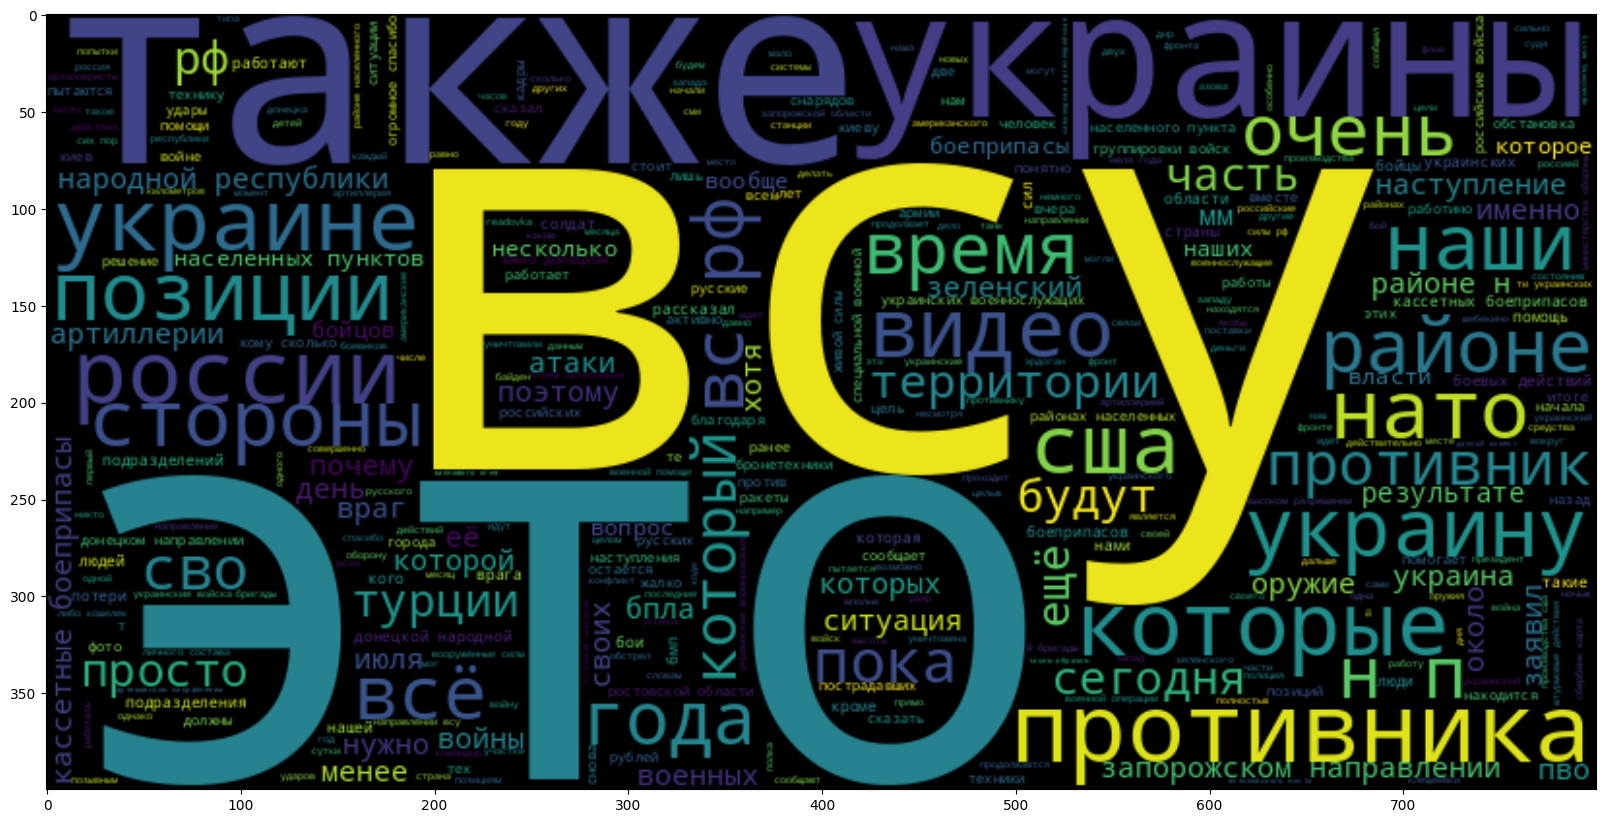

In [12]:
nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# ua_stopwords = stopwords.words("ukrainian")

plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords).generate(" ".join(train_df["Content_processed"].apply(lambda x: str(x).lower())))
plt.imshow(wc, interpolation = 'bilinear')

### Visualizations

In [13]:
device = "cpu"

In [14]:
sent_emb_model = SentenceTransformer("DeepPavlov/rubert-base-cased", device=device)

No sentence-transformers model found with name /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [15]:
train_news_embeddings, train_labels = (
    sent_emb_model.encode(
        train_df["Content_processed"].to_list(), 
        show_progress_bar=True, 
        batch_size=100
    ), 
    train_df["Suspicious_Level"]
)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
len(train_news_embeddings[0])

768

In [17]:
train_tsne_news_embeddings = TSNE(random_state=42).fit_transform(train_news_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


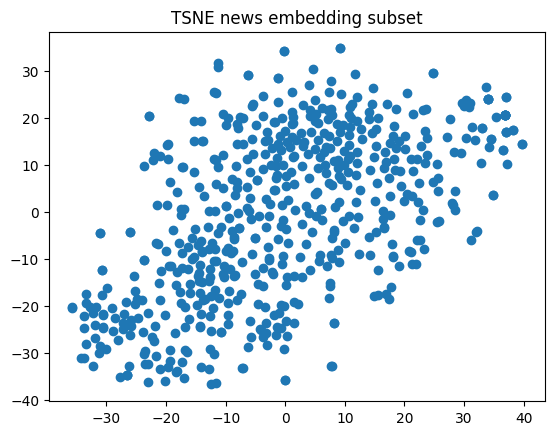

In [18]:
plt.title("TSNE news embedding subset")
plt.scatter(train_tsne_news_embeddings[:,0], train_tsne_news_embeddings[:,1])
plt.show()

In [19]:
k_means = KMeans(
    n_clusters=3, 
    random_state=42, 
    init="k-means++"
)

train_tsne_kmeans_clusts_news_embeddings = k_means.fit_predict(train_tsne_news_embeddings)

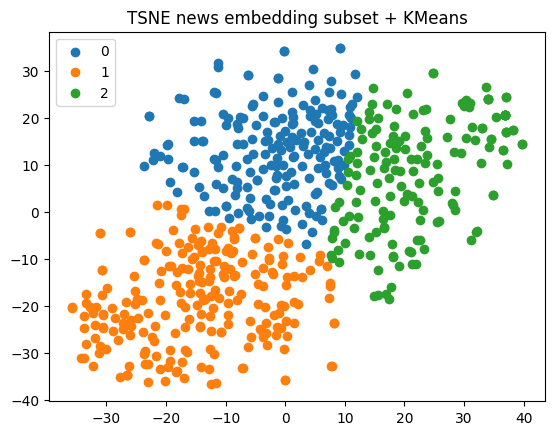

In [20]:
plt.title("TSNE news embedding subset + KMeans")
for clust in np.arange(3):
    plt.scatter(
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 0],
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [21]:
train_df[train_tsne_kmeans_clusts_news_embeddings == 2].Content.to_list()[:5]

['Анкара нарушила договорённости, отпустив главарей "Азова" (запрещен в РФ) на Украину, заявил официальный представитель Кремля Дмитрий Песков.\n\nПо его словам, турецкие власти не сообщали Москве о своем решении.\n\nПодписаться на @truekpru',
 'ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополните\xa0\xa0 СБЕРБАНК-карту: 4276160925483621\nлибо \n‼️Кошелек Ю-Мани: 410012479564046\n\n\nКому сколько не жалко. Хоть по 10 руб.\n\nОгромное спасибо и низкий поклон всем кто помогает!',
 'ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополните\xa0\xa0 СБЕРБАНК-карту: 4276160925483621\nлибо \n‼️Кошелек Ю-Мани: 410012479564046\n\n\nКому сколько не жалко. Хоть по 10 руб.\n\nОгромное спасибо и низкий поклон всем кто помогает!',
 'Вчера на эфире "60 минут" поговорили о том, как живётся нынче банкиру Фридману и отчего он поверил англо-саксам.\n\nКак нам вернуть домой русских, и нужно ли возвращать всех.\n\nИ о том, есть ли какая-то связь между тем, что одним яхту негде припарковать, а у бойцов лодок на Днепре

### Cross-validation

In [22]:
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import numpy as np

In [23]:
tsne = TSNE(n_components=2, random_state=42)

train_tsne_news_embeddings = tsne.fit_transform(train_news_embeddings)

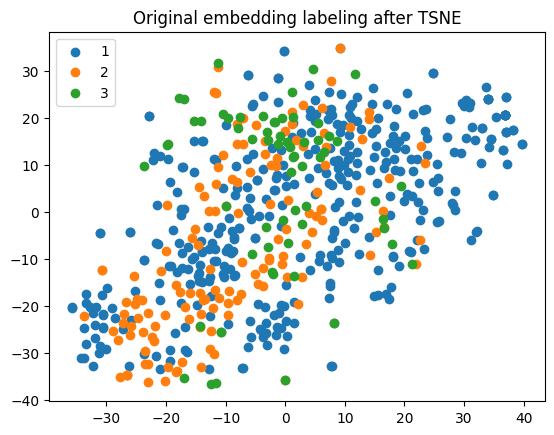

In [24]:
plt.title("Original embedding labeling after TSNE")
for clust in np.arange(1, 4):
    cluster_indices = train_labels.loc[train_labels == clust].index
    label = train_labels[train_df['Suspicious_Level'] == clust]
    plt.scatter(
        train_tsne_news_embeddings[cluster_indices, 0],
        train_tsne_news_embeddings[cluster_indices, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

#### SVM only

In [25]:
# Number of folds (K)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a counter for the fold number
fold_number = 1

X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

# Labels (y)
y = train_df['Suspicious_Level']

f1_score_folds = []
misclassified_samples = []

for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_news_embeddings, y_news_embeddings = (
        train_news_embeddings[train_index],
        train_news_embeddings[val_index]
    )
    
    # Initialize SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    
    # Train SVM model
    svm_model.fit(X_news_embeddings, y_train)
    
    # Predict using the trained SVM model
    y_pred = svm_model.predict(y_news_embeddings).reshape(-1, 1)
    
    # Evaluate the model (e.g., using f1 score)
    f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
    f1_score_folds.append(f1_score)
    
    # Print the fold number and f1 score
    print(f"Fold {fold_number} - F1 Score: {f1_score}")
    
    # Compute confusion matrix
    print(sklearn.metrics.classification_report(y_pred, y_val))

    # Increment the fold number
    fold_number += 1

f1_mean_score = np.mean(f1_score_folds)
print(f"F1 Score: {f1_mean_score}")

Fold 1 - F1 Score: 0.6368717111232081
              precision    recall  f1-score   support

           1       0.95      0.81      0.87        90
           2       0.50      0.88      0.64        16
           3       0.38      0.42      0.40        12

    accuracy                           0.78       118
   macro avg       0.61      0.70      0.64       118
weighted avg       0.83      0.78      0.79       118

Fold 2 - F1 Score: 0.7405934343434343
              precision    recall  f1-score   support

           1       0.84      0.89      0.87        73
           2       0.82      0.64      0.72        36
           3       0.54      0.78      0.64         9

    accuracy                           0.81       118
   macro avg       0.73      0.77      0.74       118
weighted avg       0.81      0.81      0.80       118

Fold 3 - F1 Score: 0.6460561772094086
              precision    recall  f1-score   support

           1       0.86      0.87      0.86        75
           2   

#### SVM with PCA

In [43]:
# Number of folds (K)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a counter for the fold number
fold_number = 1

X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

# Labels (y)
y = train_df['Suspicious_Level']

f1_score_folds = []
misclassified_samples = []

for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    pca = PCA(n_components=48, random_state=42)

    train_pca_news_embeddings = pca.fit_transform(train_news_embeddings)
    
    X_pca_news_embeddings, y_pca_news_embeddings = (
        train_pca_news_embeddings[train_index],
        train_pca_news_embeddings[val_index]
    )
    
    # Initialize SVM model
    svm_model = SVC(
        C=5.096144757282303,
        decision_function_shape='ovr',
        degree=3,
        gamma='scale',
        kernel='poly', 
        random_state=42
    )
    
    # Train SVM model
    svm_model.fit(X_pca_news_embeddings, y_train)
    
    # Predict using the trained SVM model
    y_pred = svm_model.predict(y_pca_news_embeddings).reshape(-1, 1)
    
    # Evaluate the model (e.g., using f1 score)
    f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
    f1_score_folds.append(f1_score)
    
    # Print the fold number and f1 score
    print(f"Fold {fold_number} - F1 Score: {f1_score}")
    
    # Compute confusion matrix
    print(sklearn.metrics.classification_report(y_pred, y_val))

    # Increment the fold number
    fold_number += 1

f1_mean_score = np.mean(f1_score_folds)
print(f"F1 Score: {f1_mean_score}")

Fold 1 - F1 Score: 0.43113159242191496
              precision    recall  f1-score   support

           1       0.99      0.70      0.82       109
           2       0.21      0.86      0.34         7
           3       0.08      0.50      0.13         2

    accuracy                           0.70       118
   macro avg       0.43      0.68      0.43       118
weighted avg       0.93      0.70      0.78       118

Fold 2 - F1 Score: 0.47190109184328843
              precision    recall  f1-score   support

           1       0.94      0.75      0.83        96
           2       0.50      0.70      0.58        20
           3       0.00      0.00      0.00         2

    accuracy                           0.73       118
   macro avg       0.48      0.48      0.47       118
weighted avg       0.85      0.73      0.78       118

Fold 3 - F1 Score: 0.41238719381177485
              precision    recall  f1-score   support

           1       0.95      0.70      0.80       103
           2

### Fine-tuning

In [27]:
!pip install --quiet optuna plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [28]:
import optuna

from optuna.pruners import SuccessiveHalvingPruner

In [29]:
def tune_svc_only():
    
    def objective(trial):
        kernel = "poly"
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        decision_function_shape = trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr'])
        degree = trial.suggest_int('degree', 2, 10, log=False, step=1)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        # Number of folds (K)
        num_folds = 5
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Initialize a counter for the fold number
        fold_number = 1

        X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

        # Labels (y)
        y = train_df['Suspicious_Level']

        f1_score_folds = []
        misclassified_samples = []

        for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
            # Split the data into training and validation sets
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            X_news_embeddings, y_news_embeddings = (
                train_news_embeddings[train_index],
                train_news_embeddings[val_index]
            )

            # Initialize SVM model
            svm_model = SVC(
                C=C, 
                kernel=kernel, 
                gamma=gamma,
                degree=degree, 
                decision_function_shape=decision_function_shape,
                class_weight="balanced", 
                random_state=42
            )

            # Train SVM model
            svm_model.fit(X_news_embeddings, y_train)

            # Predict using the trained SVM model
            y_pred = svm_model.predict(y_news_embeddings).reshape(-1, 1)

            # Evaluate the model (e.g., using f1 score)
            f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
            f1_score_folds.append(f1_score)

            trial.report(f1_score, fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

            # Increment the fold number
            fold_number += 1

        f1_mean_score = np.mean(f1_score_folds)

        return f1_mean_score
    
    # 1. Pruner
    pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)

    # 2. Create a Study Object
    study = optuna.create_study(pruner=pruner, direction='maximize')

    # 3. Run the Optimization Process
    study.optimize(objective, n_trials=150)  # You can adjust the number of trials
    
    # Print best hyperparameters and corresponding F1 score
    print("Best trial:")
    trial = study.best_trial
    print(f"Value: {trial.value}")
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study, trial.params

In [30]:
def tune_svc_with_pca(svc_only_params):
    
    def objective(trial):
        n_components = trial.suggest_int('n_components', 3, 100, log=False, step=1)

        # Number of folds (K)
        num_folds = 5
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Initialize a counter for the fold number
        fold_number = 1

        X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

        # Labels (y)
        y = train_df['Suspicious_Level']

        f1_score_folds = []

        for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
            # Split the data into training and validation sets
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            pca = PCA(n_components=n_components, random_state=42)

            train_pca_news_embeddings = pca.fit_transform(train_news_embeddings)

            X_pca_news_embeddings, y_pca_news_embeddings = (
                train_pca_news_embeddings[train_index],
                train_pca_news_embeddings[val_index]
            )

            train_pca_news_embeddings = pca.fit_transform(X_pca_news_embeddings)
            
            # Initialize SVM model
            svm_model = SVC(
                kernel = "poly",
                class_weight="balanced", 
                random_state=42
            )

            # Train SVM model
            svm_model.fit(train_pca_news_embeddings, y_train)

            # Predict using the trained SVM model
            y_pred = svm_model.predict(y_pca_news_embeddings).reshape(-1, 1)

            # Evaluate the model (e.g., using f1 score)
            f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
            f1_score_folds.append(f1_score)

            trial.report(f1_score, fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

            # Increment the fold number
            fold_number += 1

        f1_mean_score = np.mean(f1_score_folds)

        return f1_mean_score
    
    # 1. Pruner
    pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)

    # 2. Create a Study Object
    study = optuna.create_study(pruner=pruner, direction='maximize')

    # 3. Run the Optimization Process
    study.optimize(objective, n_trials=150)  # You can adjust the number of trials
    
    # Print best hyperparameters and corresponding F1 score
    print("Best trial:")
    trial = study.best_trial
    print(f"Value: {trial.value}")
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study, trial.params

In [31]:
svc_only_study, svc_only_params = tune_svc_only()

[I 2023-11-18 18:07:38,471] A new study created in memory with name: no-name-556da43d-93e7-4133-bd87-db675d08d189
[I 2023-11-18 18:07:38,913] Trial 0 finished with value: 0.2632287430770418 and parameters: {'C': 0.0038104770398842635, 'decision_function_shape': 'ovr', 'degree': 6, 'gamma': 'auto'}. Best is trial 0 with value: 0.2632287430770418.
[I 2023-11-18 18:07:39,339] Trial 1 finished with value: 0.2632287430770418 and parameters: {'C': 0.003019917941596946, 'decision_function_shape': 'ovo', 'degree': 8, 'gamma': 'auto'}. Best is trial 0 with value: 0.2632287430770418.
[I 2023-11-18 18:07:39,716] Trial 2 pruned. 
[I 2023-11-18 18:07:40,022] Trial 3 finished with value: 0.6443270049006838 and parameters: {'C': 1.8979712635606045, 'decision_function_shape': 'ovr', 'degree': 4, 'gamma': 'scale'}. Best is trial 3 with value: 0.6443270049006838.
[I 2023-11-18 18:07:40,413] Trial 4 finished with value: 0.42560213729495133 and parameters: {'C': 4710.198283765497, 'decision_function_shape

Best trial:
Value: 0.6642724205428384
Params: 
    C: 5.096144757282303
    decision_function_shape: ovr
    degree: 3
    gamma: scale


In [32]:
svc_with_pca_study, svc_with_pca_params = tune_svc_with_pca(svc_only_params)

[I 2023-11-18 18:08:10,979] A new study created in memory with name: no-name-5da86583-3067-4453-beb7-00e966c9a20b
[I 2023-11-18 18:08:11,325] Trial 0 finished with value: 0.4091902641014672 and parameters: {'n_components': 73}. Best is trial 0 with value: 0.4091902641014672.
[I 2023-11-18 18:08:11,387] Trial 1 pruned. 
[I 2023-11-18 18:08:11,512] Trial 2 pruned. 
[I 2023-11-18 18:08:11,635] Trial 3 pruned. 
[I 2023-11-18 18:08:11,694] Trial 4 pruned. 
[I 2023-11-18 18:08:11,803] Trial 5 pruned. 
[I 2023-11-18 18:08:11,945] Trial 6 pruned. 
[I 2023-11-18 18:08:12,175] Trial 7 pruned. 
[I 2023-11-18 18:08:12,299] Trial 8 pruned. 
[I 2023-11-18 18:08:12,415] Trial 9 pruned. 
[I 2023-11-18 18:08:12,511] Trial 10 pruned. 
[I 2023-11-18 18:08:12,772] Trial 11 finished with value: 0.42567730172870755 and parameters: {'n_components': 61}. Best is trial 11 with value: 0.42567730172870755.
[I 2023-11-18 18:08:12,876] Trial 12 pruned. 
[I 2023-11-18 18:08:12,980] Trial 13 pruned. 
[I 2023-11-18 1

Best trial:
Value: 0.4281901564681004
Params: 
    n_components: 48


#### Visualization

In [33]:
!pip install --quiet plotly ipykernel nbformat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [34]:
import optuna.visualization as vis

In [39]:
def visualize(study, params):
    optimization_history_plot = vis.plot_optimization_history(study)
    optimization_history_plot.show()
    
    param_importance_plot = vis.plot_param_importances(study)
    param_importance_plot.show()
    
    contour_plot = vis.plot_contour(study, params=params)
    contour_plot.show()

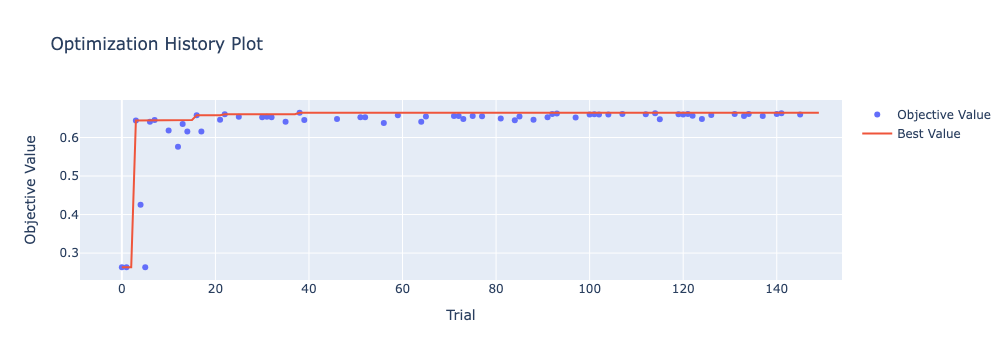

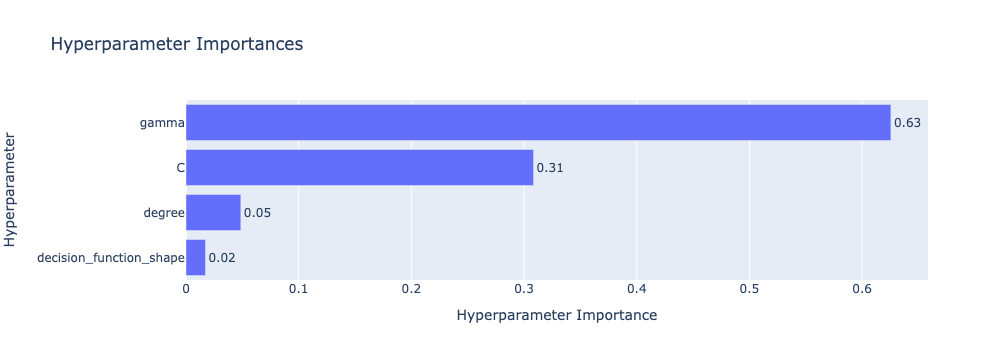

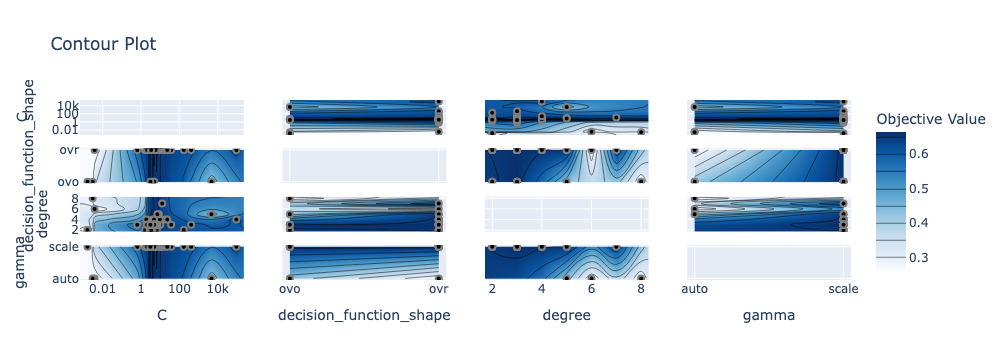

In [40]:
visualize(svc_only_study, ["C", "degree", "gamma", "decision_function_shape"])

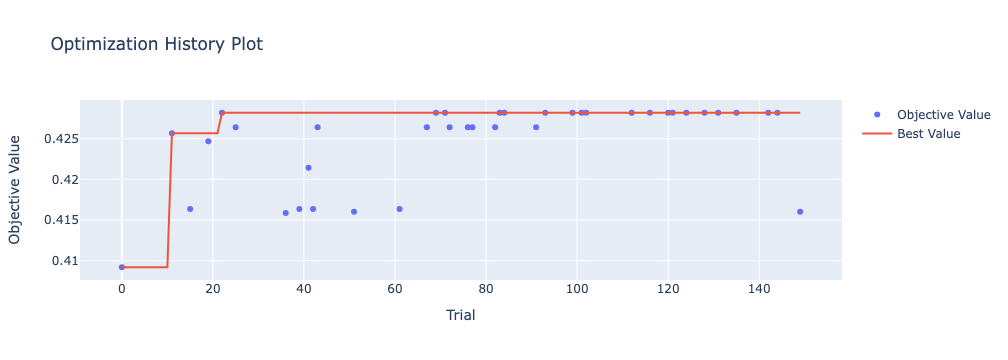

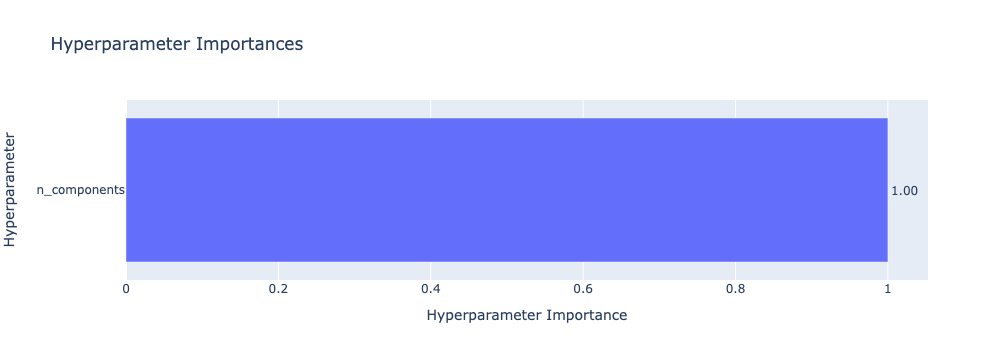

[W 2023-11-18 18:10:17,135] The length of params must be greater than 1.


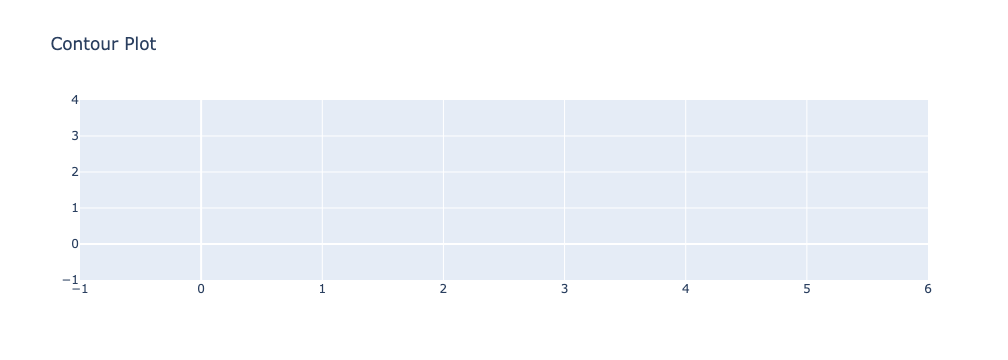

In [41]:
visualize(svc_with_pca_study, ["n_components"])

### Submission

In [ ]:
test_df["Content_processed"] = test_df["Content"].apply(process_text)

test_news_embeddings = sent_emb_model.encode(
    test_df["Content_processed"].to_list(), 
    show_progress_bar=True, 
    batch_size=100
)

In [ ]:
y_train = train_df['Suspicious_Level']

svm_model = SVC(**trial.params, random_state=42)
svm_model.fit(train_news_embeddings, y_train)

y_pred = svm_model.predict(train_news_embeddings).reshape(-1, 1)

print(sklearn.metrics.classification_report(y_pred, y_train))

test_df['Suspicious_Level'] = svm_model.predict(test_news_embeddings).reshape(-1, 1)

In [ ]:
test_df

In [ ]:
test_df[['MessageId', 'Suspicious_Level']].to_csv('submission.csv', index=False)